Importando as bibliotecas que serão usadas para o treinamento da RNA, a obtenção de métricas e a geração de gráficos:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, Nadam, SGD, AdamW, RMSprop, Adagrad
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from tabulate import tabulate

In [2]:
# Imporando o dataset
dataset = pd.read_csv("ad_click_dataset.csv")
dataset.head()


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


Descrição do dataset:

In [3]:

dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


,id,age,click
count,10000.000000,5234.000000,10000.000000
mean,5060.211400,40.197363,0.650000
std,2861.758265,13.126420,0.476993
min,5.000000,18.000000,0.000000
25%,2529.000000,29.000000,0.000000
50%,5218.000000,39.500000,1.000000
75%,7466.000000,52.000000,1.000000
max,10000.000000,64.000000,1.000000


In [4]:
dataset['gender'].value_counts()

gender
Female        1834
Male          1810
Non-Binary    1663
Name: count, dtype: int64

In [5]:
dataset['device_type'].value_counts()

device_type
Desktop    2754
Mobile     2649
Tablet     2597
Name: count, dtype: int64

In [6]:
dataset['ad_position'].value_counts()

ad_position
Bottom    2817
Top       2597
Side      2586
Name: count, dtype: int64

In [7]:
dataset['browsing_history'].value_counts()

browsing_history
Entertainment    1175
Social Media     1054
Education        1029
Shopping          984
News              976
Name: count, dtype: int64

In [8]:
dataset['time_of_day'].value_counts()

time_of_day
Morning      2126
Afternoon    2016
Evening      1958
Night        1900
Name: count, dtype: int64

In [9]:
dataset = dataset.drop(columns=['id','full_name'], axis=1)
dataset.shape

(10000, 7)

In [10]:
num_cols = dataset.select_dtypes(include=['float64', 'int64'])
cat_cols = dataset.select_dtypes(include=['object'])

print('Numeric Variables:')
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['age', 'click']

Categorical Variables:
['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']


In [11]:
dataset.describe().T


,count,mean,std,min,25%,50%,75%,max
age,5234.0,40.197363,13.126420,18.0,29.0,39.5,52.0,64.0
click,10000.0,0.650000,0.476993,0.0,0.0,1.0,1.0,1.0


Quantidade de valores nulos de cada atributo:

In [12]:
dataset.isnull().sum()

age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

In [13]:
#dataset[dataset.isnull().any(axis=1)]
dataset[dataset.isnull().any(axis=1)].shape[0]

9184

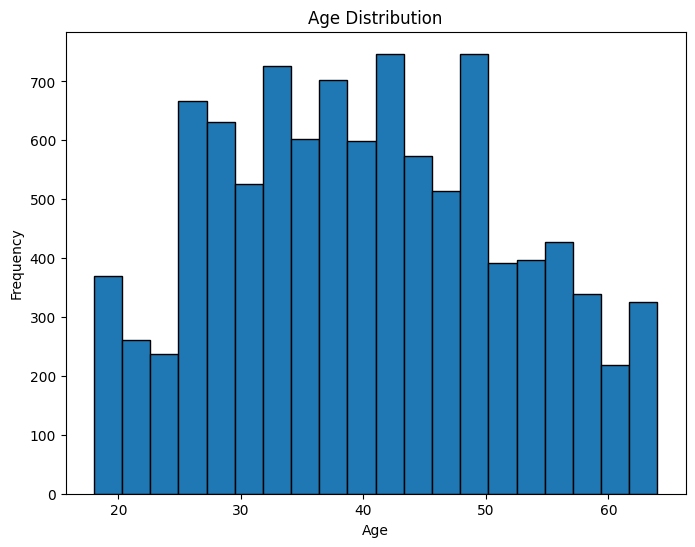

In [119]:
# Distribuição da idade 
plt.figure(figsize=(8, 6))
plt.hist(dataset['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Distribuição dos clicks por classes:

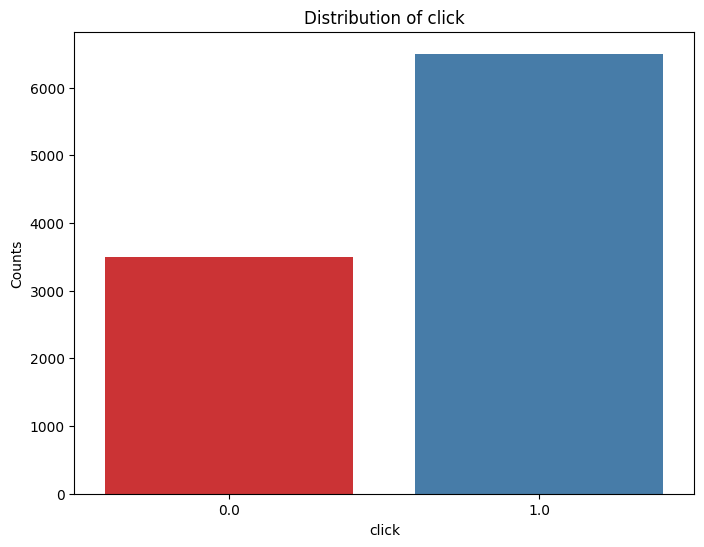

In [120]:
# Distribuição dos cliques
plt.figure(figsize=(8,6))
sns.countplot(x='click', data=dataset, palette='Set1', hue='click', legend=False)
plt.title(f'Distribution of click')
plt.xlabel('click')
plt.ylabel('Counts')
plt.show()

Tratamento dos dados:

In [16]:
# Substituindo Nan das colunas categóricas por 'Unknown'. Isso representa a falta de informação
'''dataset['gender'] = dataset['gender'].fillna('Unknown')
dataset['device_type'] = dataset['device_type'].fillna('Unknown')
dataset['ad_position'] = dataset['ad_position'].fillna('Unknown')
dataset['browsing_history'] = dataset['browsing_history'].fillna('Unknown')
dataset['time_of_day'] = dataset['time_of_day'].fillna('Unknown')'''

# Substituindo Nan das colunas categóricas pela moda
dataset["gender"] = dataset["gender"].fillna(dataset["gender"].mode()[0])
dataset["device_type"] = dataset["device_type"].fillna(dataset["device_type"].mode()[0])
dataset["ad_position"] = dataset["ad_position"].fillna(dataset["ad_position"].mode()[0])
dataset["browsing_history"] = dataset["browsing_history"].fillna(dataset["browsing_history"].mode()[0])
dataset["time_of_day"] = dataset["time_of_day"].fillna(dataset["time_of_day"].mode()[0])

dataset.head(10)

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Female,Desktop,Top,Shopping,Afternoon,1
1,NaN,Male,Desktop,Top,Entertainment,Morning,1
2,41.0,Non-Binary,Desktop,Side,Education,Night,1
3,34.0,Male,Desktop,Bottom,Entertainment,Evening,1
4,39.0,Non-Binary,Desktop,Bottom,Social Media,Morning,0
5,NaN,Non-Binary,Desktop,Bottom,Social Media,Evening,1
6,26.0,Female,Desktop,Top,Entertainment,Morning,1
7,40.0,Male,Mobile,Side,Entertainment,Evening,0
8,NaN,Non-Binary,Mobile,Bottom,Social Media,Morning,1
9,NaN,Female,Desktop,Bottom,Education,Afternoon,1


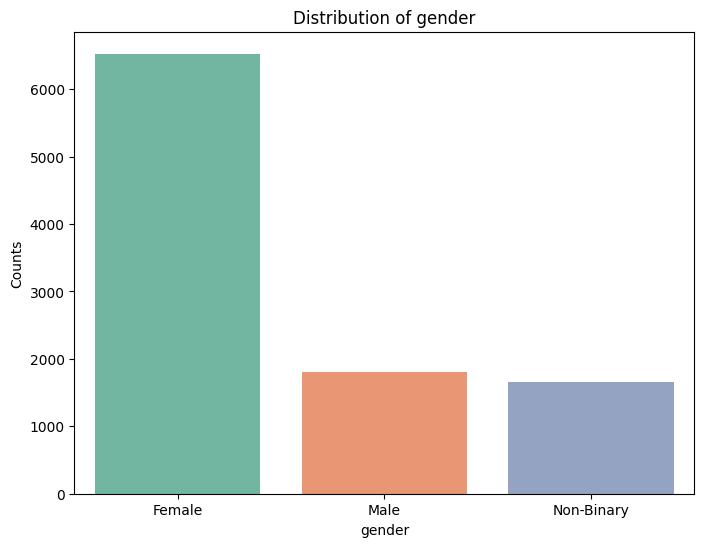

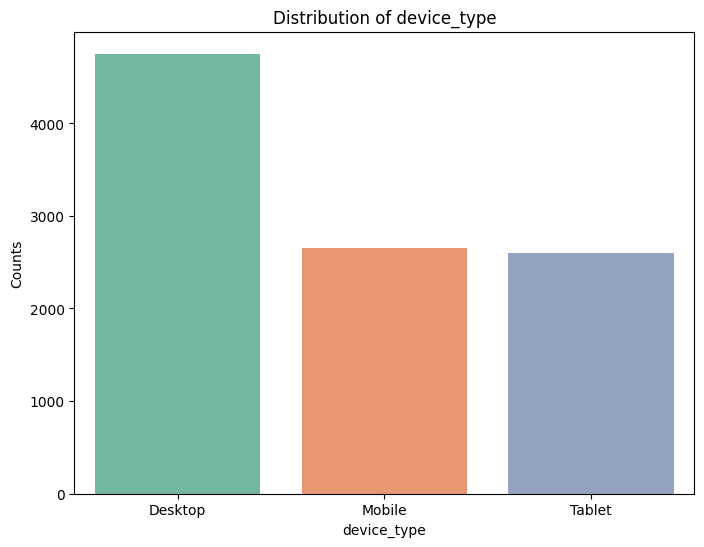

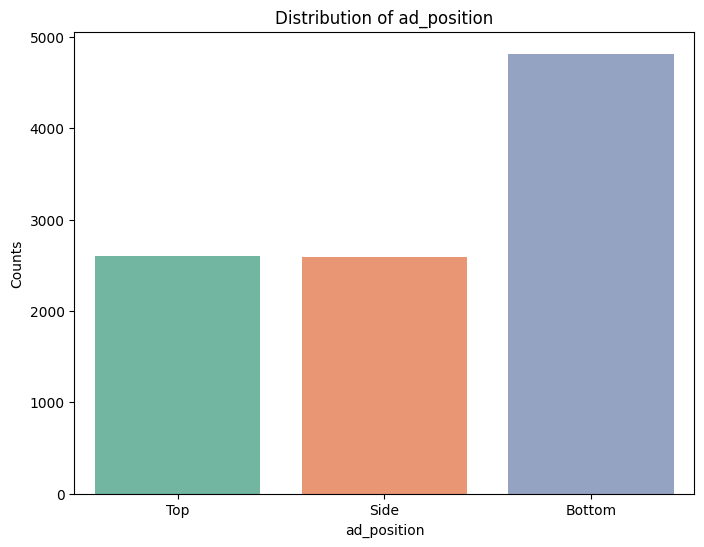

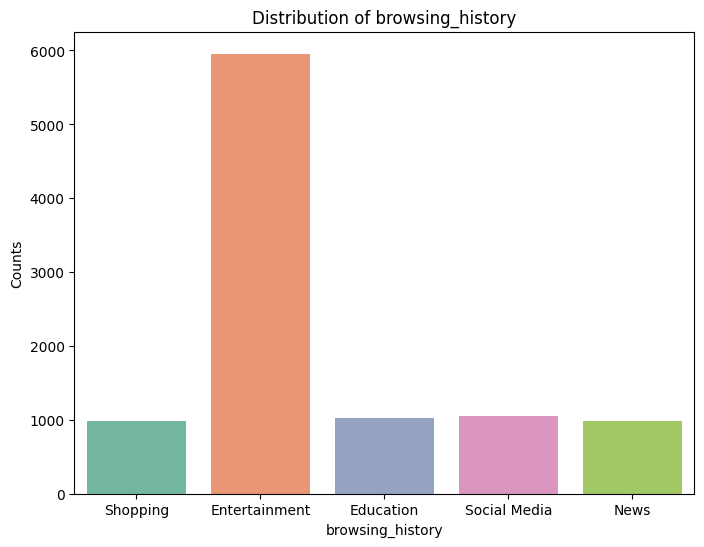

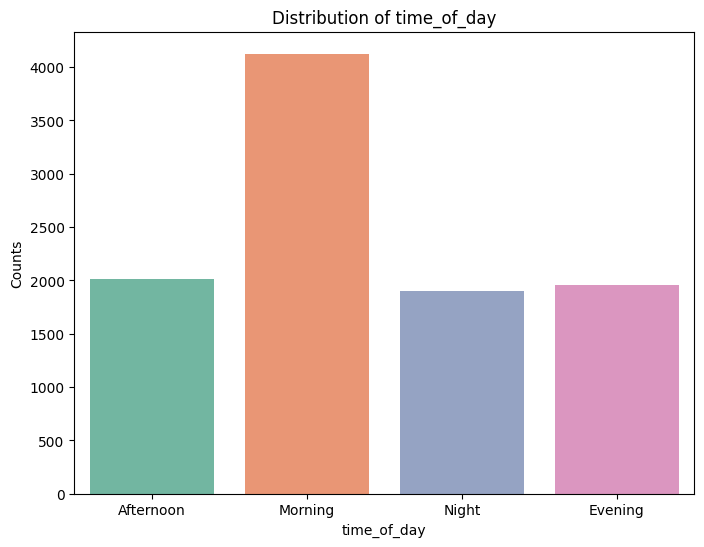

In [121]:
# Gráficos de distribuição dos atributos categóricos após a imputação de 'Unknown'
cat=['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']
for col in cat:
  plt.figure(figsize=(8,6))
  sns.countplot(x=col, data=dataset, palette="Set2", hue=col, legend=False)
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Counts')
  plt.show()


In [18]:
# No atributo numérico 'age', é feita a imputação de valores usando o algoritmo K-Nearest Neighbors
def knn_impute(data, n_neighbors):   
    data_encoded = data.copy()
    
    category_mappings = {}
    for col in data_encoded.select_dtypes(include='object').columns:
        data_encoded[col] = data_encoded[col].astype('category').cat.codes
        category_mappings[col] = dict(enumerate(data[col].astype('category').cat.categories))

    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_encoded), columns=data_encoded.columns)

    for col in data.select_dtypes(include='object').columns:
        data_imputed[col] = data_imputed[col].round().astype(int).map(category_mappings[col])
        
    return data_imputed

data_imputed = knn_impute(dataset, n_neighbors=2)
data_imputed['age'] = np.floor(data_imputed['age'])
dataset = data_imputed
dataset.head(10)

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Female,Desktop,Top,Shopping,Afternoon,1.0
1,49.0,Male,Desktop,Top,Entertainment,Morning,1.0
2,41.0,Non-Binary,Desktop,Side,Education,Night,1.0
3,34.0,Male,Desktop,Bottom,Entertainment,Evening,1.0
4,39.0,Non-Binary,Desktop,Bottom,Social Media,Morning,0.0
5,43.0,Non-Binary,Desktop,Bottom,Social Media,Evening,1.0
6,26.0,Female,Desktop,Top,Entertainment,Morning,1.0
7,40.0,Male,Mobile,Side,Entertainment,Evening,0.0
8,28.0,Non-Binary,Mobile,Bottom,Social Media,Morning,1.0
9,33.0,Female,Desktop,Bottom,Education,Afternoon,1.0


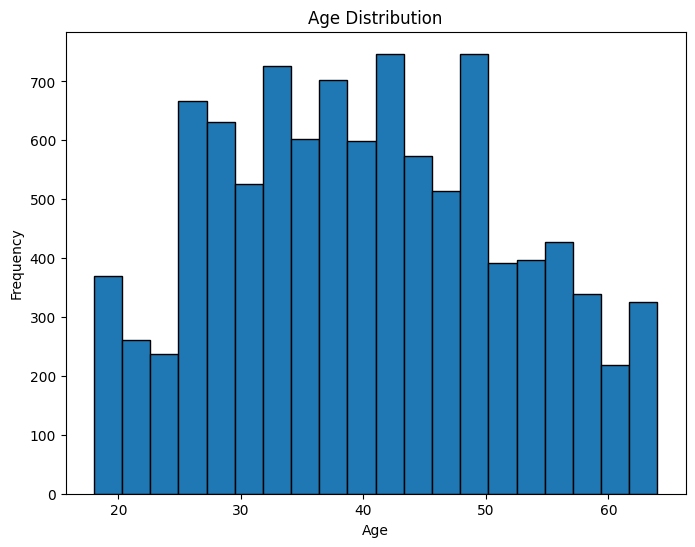

In [122]:
# Distribuição da idade após a imputação de valores
plt.figure(figsize=(8, 6))
plt.hist(dataset['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

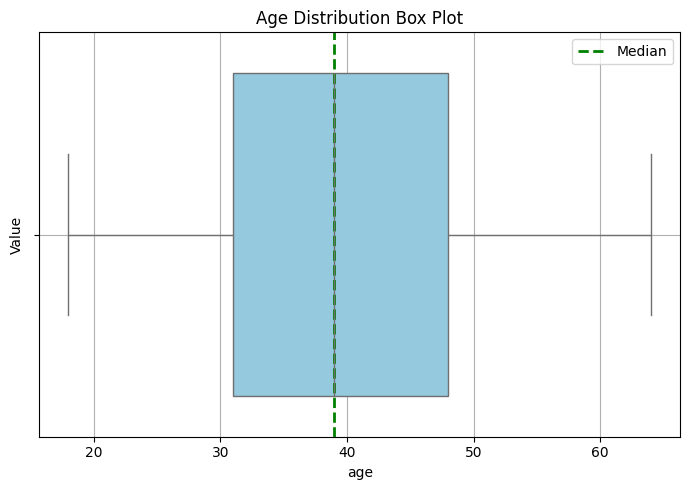

In [123]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=dataset, x="age", color='skyblue', flierprops=dict(marker='o', markersize=8, markerfacecolor='red'))
plt.title('Age Distribution Box Plot')
plt.xlabel('age')
plt.ylabel('Value')
median_age = dataset['age'].median()
plt.axvline(median_age, color='green', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Não há mais valores nulos no dataset
dataset.isnull().sum()

age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64

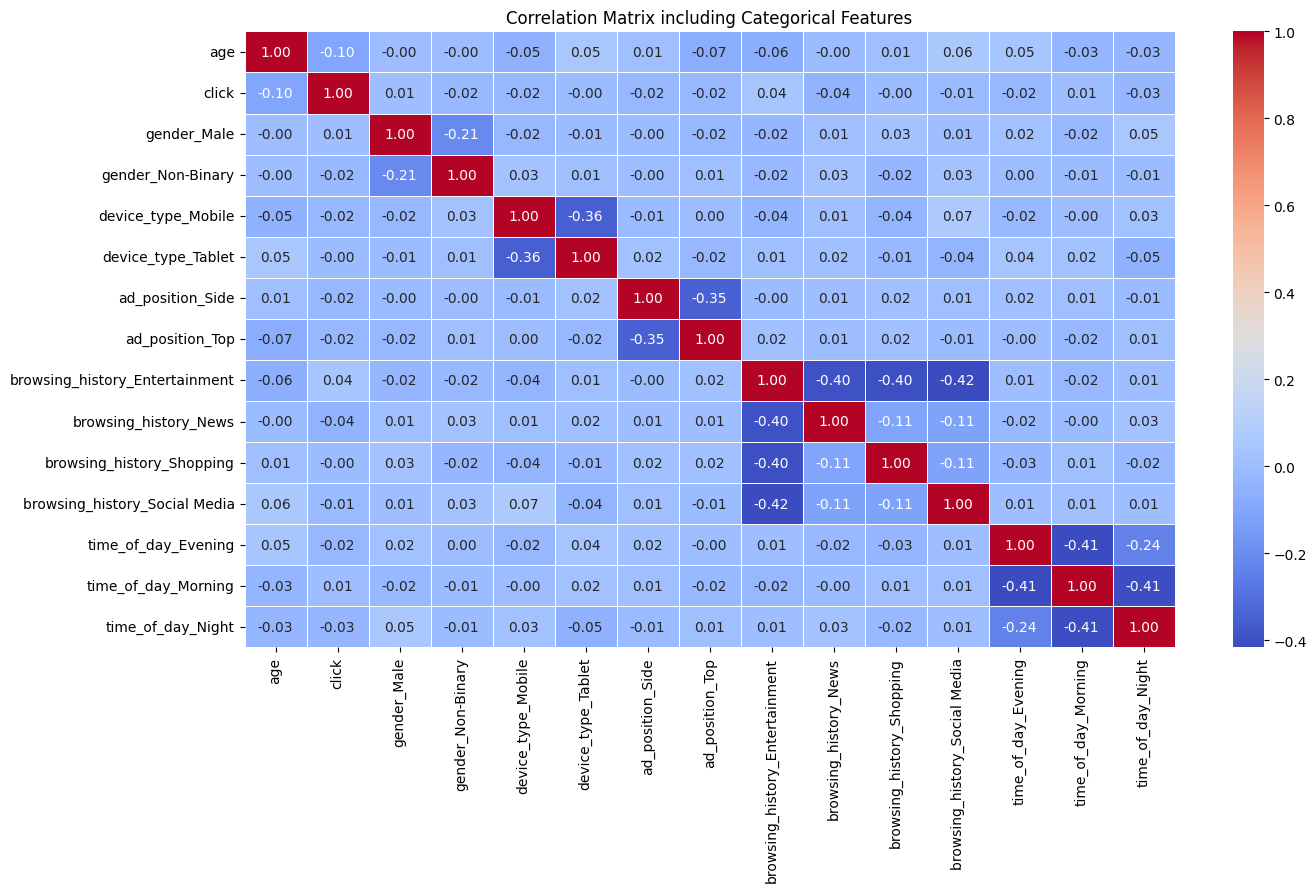

In [124]:
# Matriz de correlação
data_encoded = pd.get_dummies(dataset, drop_first=True)
corr_matrix = data_encoded.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [23]:
# Separando as variáveis independentes (entrada) das variáveis dependendes (saída)
x = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
x

,age,gender,device_type,ad_position,browsing_history,time_of_day
0,22.0,Female,Desktop,Top,Shopping,Afternoon
1,49.0,Male,Desktop,Top,Entertainment,Morning
2,41.0,Non-Binary,Desktop,Side,Education,Night
3,34.0,Male,Desktop,Bottom,Entertainment,Evening
4,39.0,Non-Binary,Desktop,Bottom,Social Media,Morning
...,...,...,...,...,...,...
9995,40.0,Female,Mobile,Top,Education,Morning
9996,46.0,Female,Desktop,Bottom,Entertainment,Morning
9997,40.0,Male,Mobile,Side,Entertainment,Morning
9998,45.0,Female,Desktop,Bottom,Shopping,Morning


In [24]:
# Transformando os dados categóricos em numéricos utilizando o One-hot Encoding
categorical_columns = x.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(x[categorical_columns])
one_hot_dataset = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
x = pd.concat([x, one_hot_dataset], axis=1)
x = x.drop(categorical_columns, axis=1)
#print(f"Dados categóricos convertidos : \n{x}")
x

,age,gender_Female,gender_Male,gender_Non-Binary,device_type_Desktop,device_type_Mobile,device_type_Tablet,ad_position_Bottom,ad_position_Side,ad_position_Top,browsing_history_Education,browsing_history_Entertainment,browsing_history_News,browsing_history_Shopping,browsing_history_Social Media,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,22.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,49.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,41.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,34.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,39.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9996,46.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9997,40.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9998,45.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Preparando o treinamento da RNA:

In [25]:
# Separando o conjunto de testes e o conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42)

# Balanceando o conjunto de treinamento
smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state = 42)
adasyn = ADASYN(random_state = 42)
#X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

X_train, y_train = smote.fit_resample(X_train, y_train)

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape
#X_test.shape

(9110, 19)

In [ ]:
# Definição do modelo MLP, 3 camadas ocultas com 38 neurônios e função de ativação ReLu. 
# Camada de saída com um neurônio e função de ativação Sigmoid
# A camada Dropout ignora aleatóriamente 20% dos neurônios
model = Sequential([
  InputLayer(shape=(19,), kernel_initializer='he_normal'),
  Dense(38, activation='relu'),
  Dense(38, activation='relu'),
  Dense(38, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='binary_accuracy', patience=14, mode='max', min_delta=0.001, restore_best_weights=True)
optimizer = Adam(learning_rate=0.0008)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[BinaryAccuracy(threshold=0.5)])
history = model.fit(X_train, y_train, batch_size=32, epochs=120, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

In [28]:
# Executa e coleta as métricas do treinamento com cada método de balanceamento. Cada método é executado n vezes

'''models = {'Oversampling': (X_train_ros, y_train_ros), 'SMOTE': (X_train_smote, y_train_smote), 'ADASYN': (X_train_adasyn, y_train_adasyn)}
results = {}
for method, (X_bal, y_bal) in models.items():
    roc_auc_scores = []
    #classification_reports = []
    accuracies = []
    f1_scores = []
    recalls = []
    X_bal = scaler.fit_transform(X_bal)
    #X_test = scaler.transform(X_test)
    for i in range(5):
        print(method, i)
        model = Sequential([
            InputLayer(shape=(19,), kernel_initializer='he_normal'),
            Dense(38, activation='relu'),
            Dense(38, activation='relu'),
            Dense(38, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

        optimizer = Adam(learning_rate=0.0008)
        early_stopping = EarlyStopping(monitor='binary_accuracy', patience=14, mode='max', min_delta=0.001, restore_best_weights=True)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[BinaryAccuracy(threshold=0.5)])
        model.fit(X_train, y_train, batch_size=32, epochs=120, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
  
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5)
    
        roc_auc = roc_auc_score(y_test, y_pred)
        roc_auc_scores.append(roc_auc)
    
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
        f1_scor = f1_score(y_test, y_pred)
        f1_scores.append(f1_scor)
    
        recall = recall_score(y_test, y_pred)
        recalls.append(recall)
        #classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    results[method] = {
            'accuracy_score_mean': np.mean(accuracies),
            'f1_score_mean': np.mean(f1_scores),
            'recall_score_mean': np.mean(recalls),
            'roc_auc_mean': np.mean(roc_auc_scores)
        }'''

"models = {'Oversampling': (X_train_ros, y_train_ros), 'SMOTE': (X_train_smote, y_train_smote), 'ADASYN': (X_train_adasyn, y_train_adasyn)}\nresults = {}\nfor method, (X_bal, y_bal) in models.items():\n    roc_auc_scores = []\n    #classification_reports = []\n    accuracies = []\n    f1_scores = []\n    recalls = []\n    X_bal = scaler.fit_transform(X_bal)\n    #X_test = scaler.transform(X_test)\n    for i in range(5):\n        print(method, i)\n        model = Sequential([\n            InputLayer(shape=(19,), kernel_initializer='he_normal'),\n            Dense(38, activation='relu'),\n            Dense(38, activation='relu'),\n            Dense(38, activation='relu'),\n            Dropout(0.2),\n            Dense(1, activation='sigmoid')\n        ])\n\n        model.compile(optimizer= Nadam(learning_rate=0.0007, beta_1=0.85, beta_2=0.996, weight_decay=0.02), loss='binary_crossentropy', metrics=[BinaryAccuracy(threshold=0.5)])\n        model.fit(X_train, y_train, batch_size=32, epochs

In [ ]:
# Executa e coleta as métricas do treinamento com cada otimizador. Cada otimizador é executado n vezes
'''otimizadores = {
    'SGD': lambda: SGD(),
    'Adagrad': lambda: Adagrad(),
    'RMSprop': lambda: RMSprop(),
    'Adam': lambda: Adam(),
    'Adam_opt': lambda: Adam(learning_rate=0.0008, weight_decay=0.01),
    'AdamW': lambda: AdamW(),
    'Nadam': lambda: Nadam(),
    'Nadam_opt': lambda: Nadam(learning_rate=0.0008, weight_decay=0.01)
}
results = {}
reports = {name: [] for name in otimizadores.keys()}

for name, optimizer_class in otimizadores.items():
    roc_auc_scores = []
    accuracies = []
    f1_scores = []
    recalls = []
    report = []

    for i in range(8):
        print(name, i)
        
        # Cria uma nova instância do otimizador para cada execução
        optimizer = optimizer_class()

        model = Sequential([
            InputLayer(shape=(19,), kernel_initializer='he_normal'),
            Dense(38, activation='relu'),
            Dense(38, activation='relu'),
            Dense(38, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        
        early_stopping = EarlyStopping(monitor='binary_accuracy', patience=14, mode='max', min_delta=0.001, restore_best_weights=True)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[BinaryAccuracy(threshold=0.5)])
        model.fit(X_train, y_train, batch_size=32, epochs=120, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)

        roc_auc = roc_auc_score(y_test, y_pred)
        roc_auc_scores.append(roc_auc)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        report = classification_report(y_test, y_pred, output_dict=True)
        reports[name].append(report)
        
        recall = recall_score(y_test, y_pred)
        recalls.append(recall)
    
        f1_scor = f1_score(y_test, y_pred)
        f1_scores.append(f1_scor)

    results[name] = {
            'accuracy_score_mean': np.mean(accuracies),
            'f1_score_mean': np.mean(f1_scores),
            'recall_score_mean': np.mean(recalls),
            'roc_auc_mean': np.mean(roc_auc_scores)
    }'''


In [99]:
# Acurácia da RNA
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7997 - loss: 0.5536
Acurácia: 0.8016666769981384


In [100]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# Exibe as métricas
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72      1055
         1.0       0.86      0.84      0.85      1945

    accuracy                           0.80      3000
   macro avg       0.78      0.79      0.78      3000
weighted avg       0.80      0.80      0.80      3000



'plt.figure(figsize=(8,6))\nsns.heatmap(cm, annot=True, fmt="d", cmap="Blues")\nplt.title(\'Confusion Matrix\')\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\nplt.show()\n'

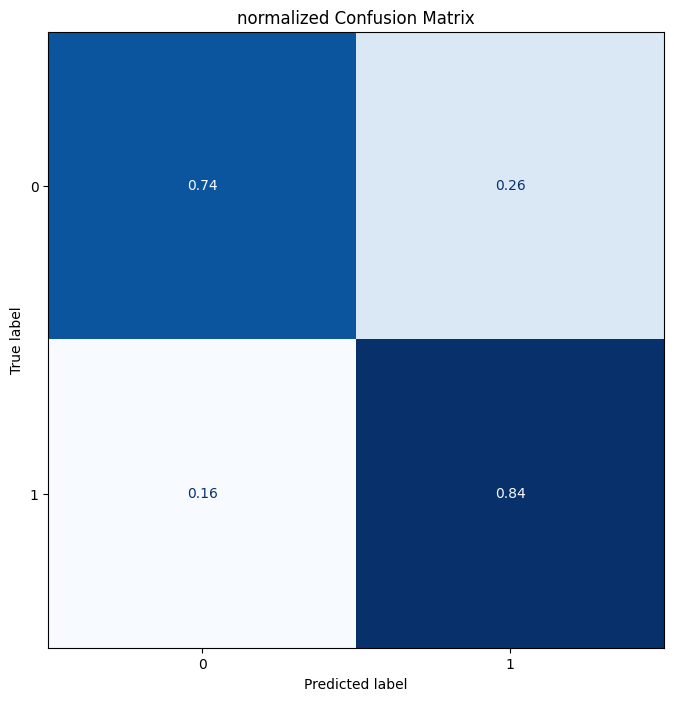

In [108]:
# Matriz de confusão exibindo a porcentagem de acerto / erro de cada classe
cm=confusion_matrix(y_test,y_pred,normalize='true')
fig,ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',values_format='.2f',ax=ax,colorbar=False)
plt.title('normalized Confusion Matrix')
plt.show()


In [34]:
# Exibe as médias por classe das métricas coletadas na execução de diferentes otimizadores
'''from collections import defaultdict

# Cria a lista para armazenar as médias
average_metrics = []

for name, report_list in reports.items():
    # Inicializa um acumulador para cada métrica por classe
    metrics_sum = defaultdict(lambda: defaultdict(float))
    accuracy_sum = 0  # Acumulador para accuracy
    num_reports = len(report_list)
    
    for report in report_list:
        accuracy_sum += report.get("accuracy", 0.0)  # Acumula accuracy para cada execução
        for class_label in ['0.0', '1.0']:
            if class_label in report:
                metrics_sum[class_label]["precision"] += report[class_label].get("precision", 0.0)
                metrics_sum[class_label]["recall"] += report[class_label].get("recall", 0.0)
                metrics_sum[class_label]["f1-score"] += report[class_label].get("f1-score", 0.0)
                metrics_sum[class_label]["support"] += report[class_label].get("support", 0.0)
    
    # Calcula a média das métricas
    metrics_avg = {
        "optimizer": name,
        "accuracy_mean": accuracy_sum / num_reports,  # Calcula a média de accuracy
        "class_0": {
            "precision": metrics_sum['0.0']["precision"] / num_reports,
            "recall": metrics_sum['0.0']["recall"] / num_reports,
            "f1-score": metrics_sum['0.0']["f1-score"] / num_reports,
            "support": metrics_sum['0.0']["support"] / num_reports
        },
        "class_1": {
            "precision": metrics_sum['1.0']["precision"] / num_reports,
            "recall": metrics_sum['1.0']["recall"] / num_reports,
            "f1-score": metrics_sum['1.0']["f1-score"] / num_reports,
            "support": metrics_sum['1.0']["support"] / num_reports
        }
    }
    
    average_metrics.append(metrics_avg)

# Exibe as médias de cada otimizador
for metrics in average_metrics:
    print(f"Optimizer: {metrics['optimizer']}")
    print(f"Accuracy Mean: {metrics['accuracy_mean']:.4f}")
    print("Class 0 Metrics:", metrics['class_0'])
    print("Class 1 Metrics:", metrics['class_1'])
    print("\n" + "-" * 40 + "\n")'''

Optimizer: SGD
Accuracy Mean: 0.7458
Class 0 Metrics: {'precision': 0.6453534509643747, 'recall': 0.6431279620853081, 'f1-score': 0.64027467873749, 'support': 1055.0}
Class 1 Metrics: {'precision': 0.8063130719152106, 'recall': 0.801413881748072, 'f1-score': 0.8023339069692241, 'support': 1945.0}

----------------------------------------

Optimizer: Adagrad
Accuracy Mean: 0.5785
Class 0 Metrics: {'precision': 0.41905599806057087, 'recall': 0.5123222748815166, 'f1-score': 0.4606343413070658, 'support': 1055.0}
Class 1 Metrics: {'precision': 0.6990997331968122, 'recall': 0.614331619537275, 'f1-score': 0.6536591268261285, 'support': 1945.0}

----------------------------------------

Optimizer: RMSprop
Accuracy Mean: 0.7905
Class 0 Metrics: {'precision': 0.7085895661540933, 'recall': 0.6932464454976304, 'f1-score': 0.6990642761062837, 'support': 1055.0}
Class 1 Metrics: {'precision': 0.8359154731703502, 'recall': 0.8431876606683805, 'f1-score': 0.8389345866996721, 'support': 1945.0}

-----

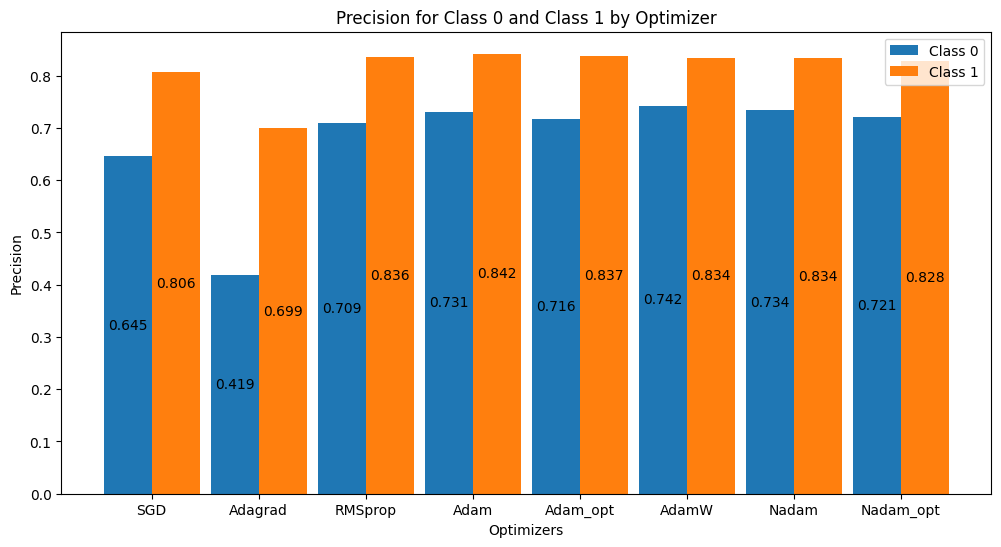

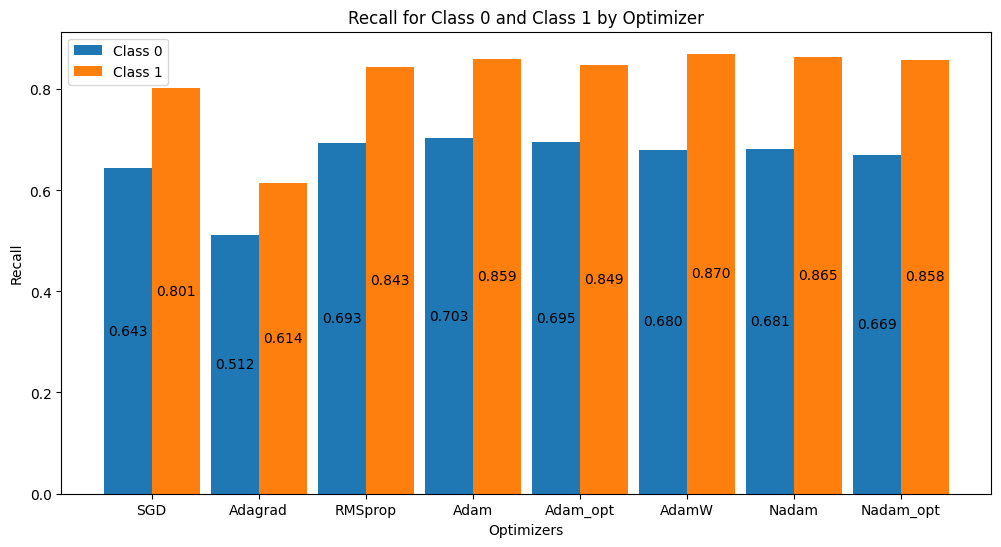

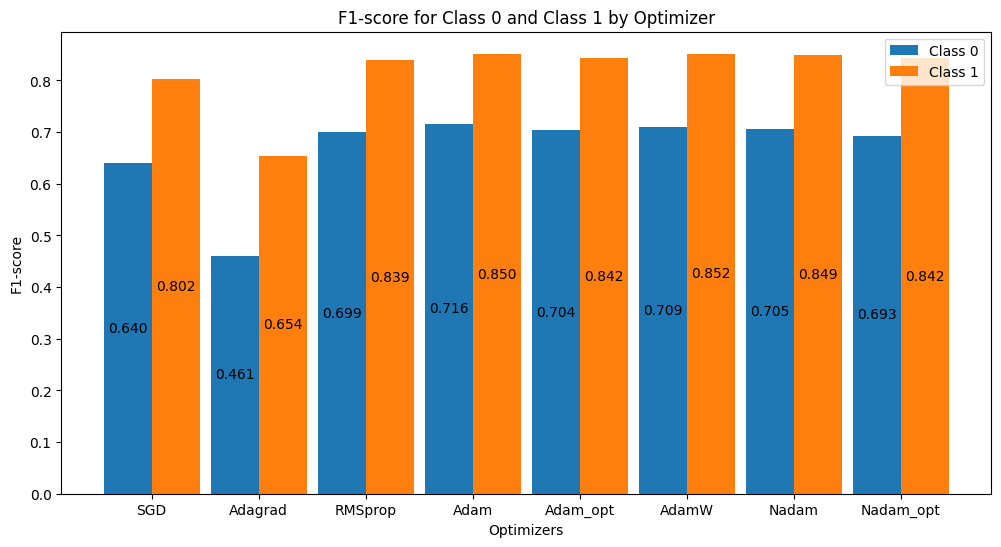

In [68]:
# Gera os gráficos que mostram as métricas de execuções utilizando diferentes otimizadores
'''optimizers = [m['optimizer'] for m in average_metrics]
class_0_precision = [m['class_0']['precision'] for m in average_metrics]
class_1_precision = [m['class_1']['precision'] for m in average_metrics]
class_0_recall = [m['class_0']['recall'] for m in average_metrics]
class_1_recall = [m['class_1']['recall'] for m in average_metrics]
class_0_f1 = [m['class_0']['f1-score'] for m in average_metrics]
class_1_f1 = [m['class_1']['f1-score'] for m in average_metrics]

# Configurações do gráfico
x = np.arange(len(optimizers)) 
width = 0.45  

# Precision
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, class_0_precision, width, label='Class 0')
bars2 = plt.bar(x + width/2, class_1_precision, width, label='Class 1')
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
             f'{bar.get_height():.3f}', ha='center', va='center', color='black')
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
             f'{bar.get_height():.3f}', ha='center', va='center', color='black')
plt.xticks(x, optimizers)
plt.xlabel('Optimizers')
plt.ylabel('Precision')
plt.title('Precision for Class 0 and Class 1 by Optimizer')
plt.legend()
plt.show()

# Recall
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, class_0_recall, width, label='Class 0')
bars2 = plt.bar(x + width/2, class_1_recall, width, label='Class 1')
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
             f'{bar.get_height():.3f}', ha='center', va='center', color='black')
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
             f'{bar.get_height():.3f}', ha='center', va='center', color='black')
plt.xticks(x, optimizers)
plt.xlabel('Optimizers')
plt.ylabel('Recall')
plt.title('Recall for Class 0 and Class 1 by Optimizer')
plt.legend()
plt.show()

# F1-score
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, class_0_f1, width, label='Class 0')
bars2 = plt.bar(x + width/2, class_1_f1, width, label='Class 1')
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
             f'{bar.get_height():.3f}', ha='center', va='center', color='black')
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
             f'{bar.get_height():.3f}', ha='center', va='center', color='black')
plt.xticks(x, optimizers)
plt.xticks(x, optimizers)
plt.xlabel('Optimizers')
plt.ylabel('F1-score')
plt.title('F1-score for Class 0 and Class 1 by Optimizer')
plt.legend()
plt.show()'''

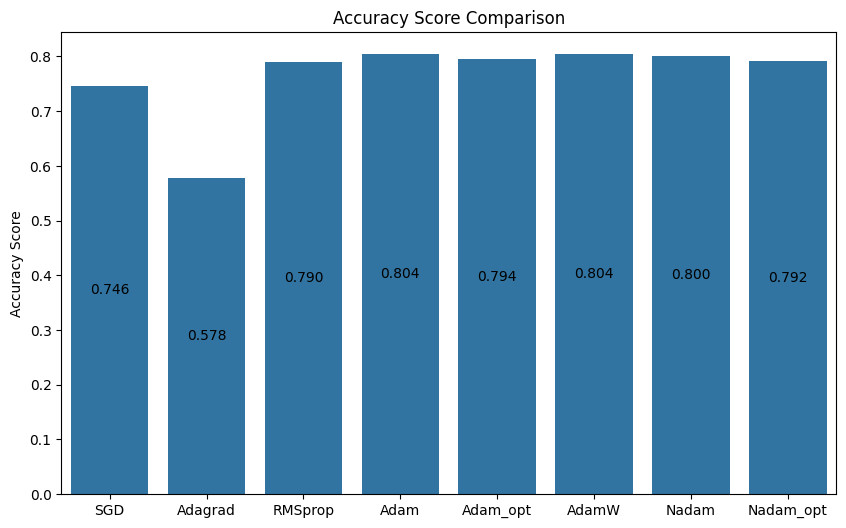

In [69]:
# Gráfico com a acurácia média de cada otimizador ou método de balanceamento
'''methods = list(results.keys())
accuraciess = [results[method]['accuracy_score_mean'] for method in methods]
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=methods, y=accuraciess)
plt.title('Accuracy Score Comparison')
plt.ylabel('Accuracy Score')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,  
        p.get_height() / 2, 
        f'{p.get_height():.3f}', 
        ha='center', va='center', color='black'
    )
plt.show()'''

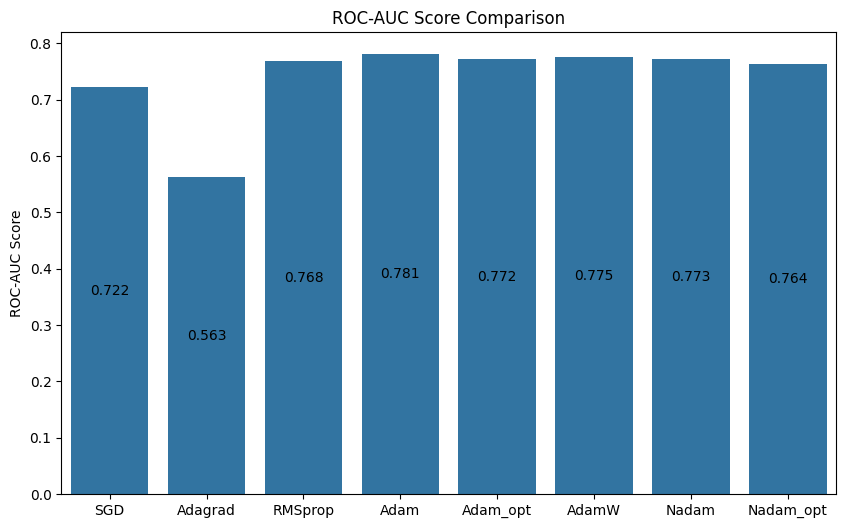

In [72]:
# Gráfico com o ROC AUC score médio de cada otimizador ou método de balanceamento
'''methods = list(results.keys())
roc_aucs = [results[method]['roc_auc_mean'] for method in methods]
#print(type(roc_aucs), roc_aucs)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=methods, y=roc_aucs)
plt.title('ROC-AUC Score Comparison')
plt.ylabel('ROC-AUC Score')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,  
        p.get_height() / 2, 
        f'{p.get_height():.3f}', 
        ha='center', va='center', color='black'
    )
plt.show()'''

In [103]:
# Salva o modelo
model.save('adclick_model.keras')
# Carrega o modelo
model = load_model('adclick_model.keras')
model.summary()


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_276 (Dense)               │ (None, 38)             │           760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 38)             │         1,482 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 38)             │         1,482 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 1)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,291 (44.11 KB)

 Trainable params: 3,763 (14.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,528 (29.41 KB)

Predição a partir dos dados de testes:

In [104]:
y_predi = model.predict(X_test)
random_idx = np.random.randint(0, X_test.shape[0])
linha_teste = X_test[random_idx].reshape(1, -1)  
predicao = model.predict(linha_teste)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Mais métricas:

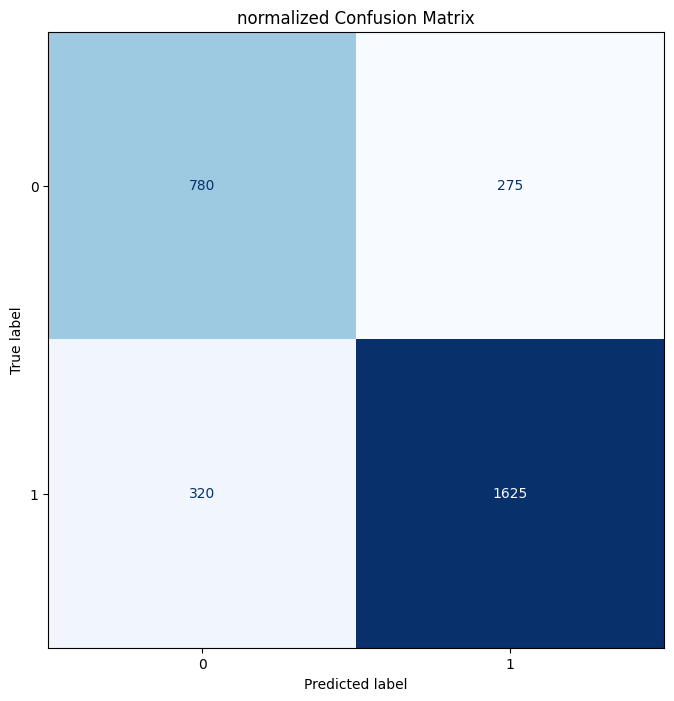

In [107]:
cm = confusion_matrix(y_test, y_predi.round())
fig,ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',ax=ax,colorbar=False)
plt.title('normalized Confusion Matrix')
plt.show()

A ROC Curve avalia o desempenho de um modelo de classificação binária, mostrando a relação entre a taxa de falsos positivos. O objetivo é avaliar quão bem o modelo consegue separar as classes (0 e 1), quanto mais perto do eixo y, melhor é a avaliação. Já AUC (Area Under the Curve) é exibida como uma métrica que quantifica a performance geral: quanto mais próximo de 1, melhor a performance.

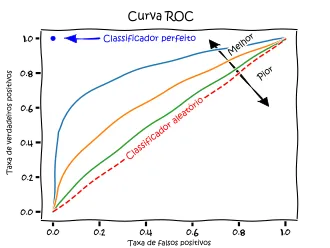

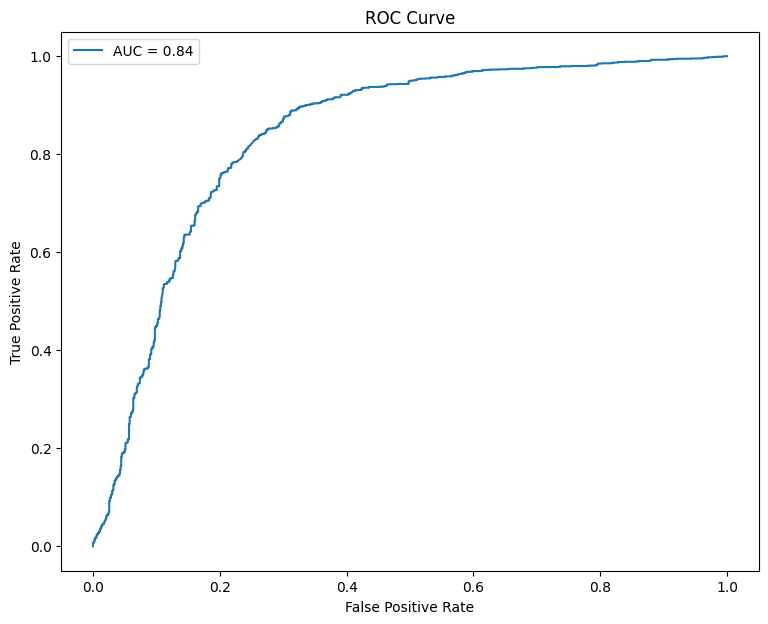

In [116]:
fpr, tpr, _ = roc_curve(y_test, y_predi)
plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Gráfico de distribuição de frequência. Uma concentração de previsões próximas de 0 ou 1 indica que o modelo tem alta certeza para a maioria das instâncias.
Distribuições com picos em valores intermediários, como 0.4 ou 0.6, sugerem que o modelo possui incertezas.

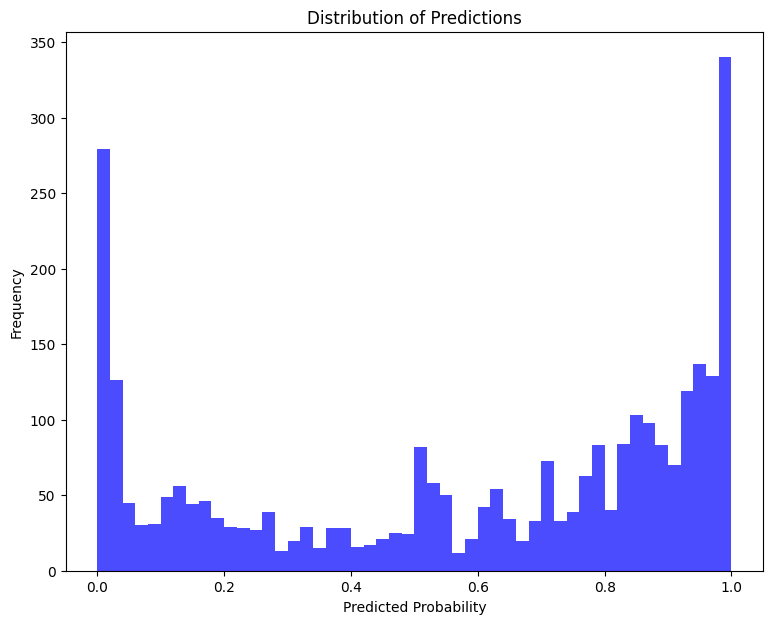

In [117]:
plt.figure(figsize=(9, 7))
plt.hist(y_predi, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [114]:
# Simulando uma entrada a partir do conjunto de teste
random_idx = np.random.randint(0, X_test.shape[0])
new_input = X_test[random_idx].reshape(1, -1)  

predicao = model.predict(new_input)
predicted_class = 1 if predicao >= 0.5 else 0

original_class = y_test.iloc[random_idx]  

print(f"Classe prevista: {predicted_class}")
print(f"Classe original: {original_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classe prevista: 1
Classe original: 1.0
